🔄 Loading Feature Names...
   Found 49 unique features.
🔄 Loading and Concatenating Data Files...
✅ Combined Data Shape: (2540047, 49)

📊 Generating Advanced Visualizations...


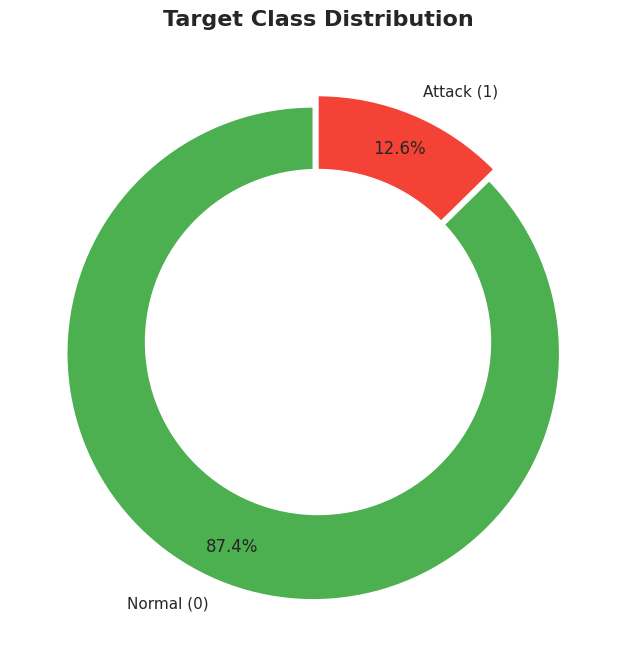

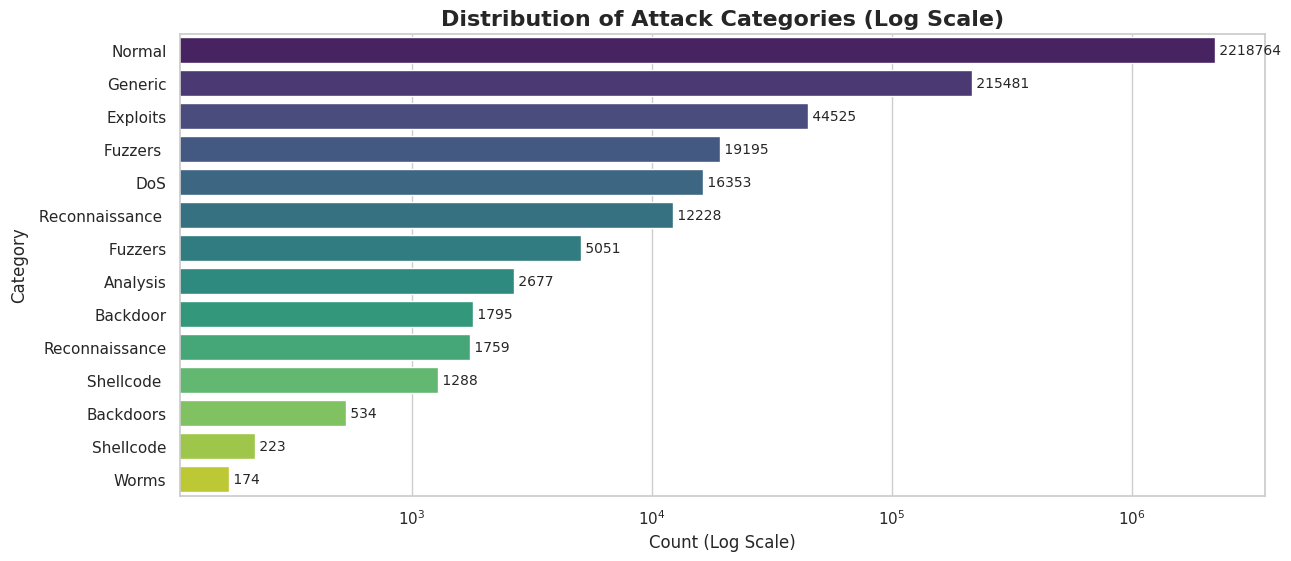

   Calculating correlations (Sampling 10% for speed)...


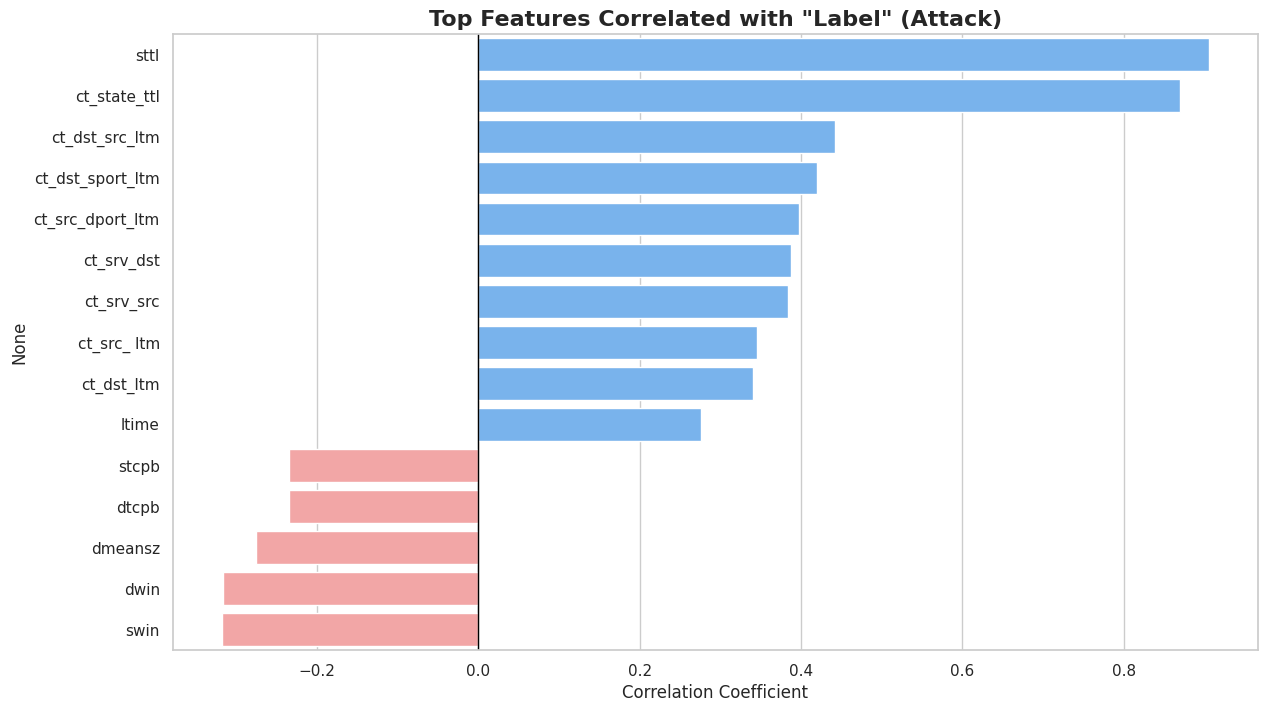

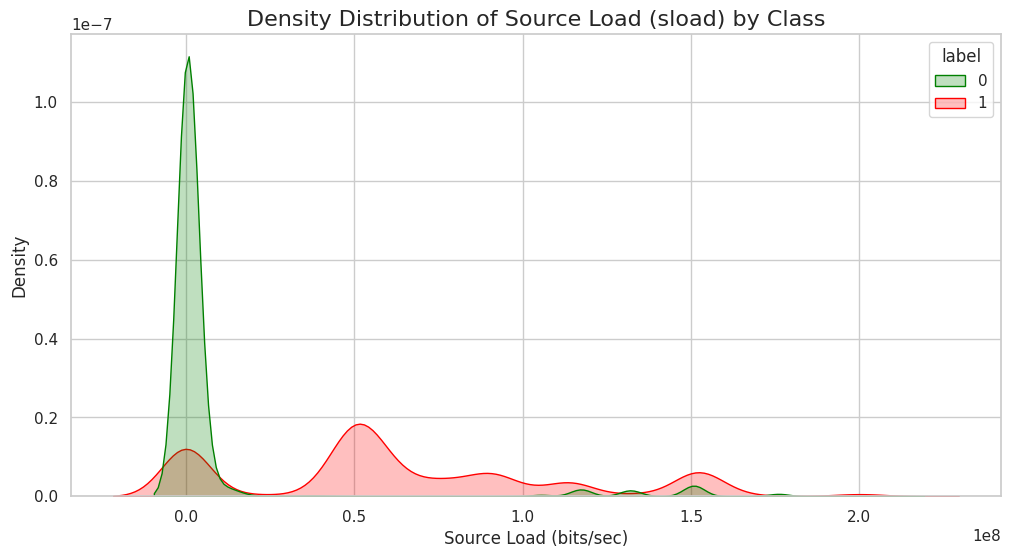

✅ Advanced EDA Complete. Proceed to Preprocessing Cell.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import warnings

# ==========================================
# 1. Setup & Visual Config
# ==========================================
dataset_path = '/content/drive/MyDrive/BTP'
features_file = dataset_path + '/UNSW-NB15_features.csv'
data_files = [
    dataset_path + '/UNSW-NB15_1.csv',
    dataset_path + '/UNSW-NB15_2.csv',
    dataset_path + '/UNSW-NB15_3.csv',
    dataset_path + '/UNSW-NB15_4.csv'
]

# 🎨 Professional Plotting Theme
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 2. Data Loading
# ==========================================
print("🔄 Loading Feature Names...")
try:
    features_df = pd.read_csv(features_file, encoding='ISO-8859-1')
except FileNotFoundError:
    print("⚠️ Standard file not found. Trying alternative name...")
    features_df = pd.read_csv(dataset_path + '/UNSW-NB15_features.csv', encoding='ISO-8859-1')

feature_names = features_df['Name'].tolist()

# Clean headers
seen = set()
cleaned_feature_names = []
for col in feature_names:
    col_lower = col.lower().strip()
    if col_lower not in seen:
        cleaned_feature_names.append(col_lower)
        seen.add(col_lower)

# Ensure targets exist
if 'attack_cat' not in cleaned_feature_names: cleaned_feature_names.append('attack_cat')
if 'label' not in cleaned_feature_names: cleaned_feature_names.append('label')

print(f"   Found {len(cleaned_feature_names)} unique features.")

print("🔄 Loading and Concatenating Data Files...")
# low_memory=False handles mixed types in columns like 'sport'
df_list = [pd.read_csv(fp, header=None, names=cleaned_feature_names, low_memory=False) for fp in data_files]
df = pd.concat(df_list, ignore_index=True)
print(f"✅ Combined Data Shape: {df.shape}")

# ==========================================
# 3. Advanced Exploratory Data Analysis (EDA)
# ==========================================
print("\n📊 Generating Advanced Visualizations...")

# --- A. Donut Chart for Class Balance ---
plt.figure(figsize=(8, 8))
class_counts = df['label'].value_counts()
colors = ['#4CAF50', '#F44336'] # Green for Normal, Red for Attack
# Create Pie
plt.pie(class_counts, labels=['Normal (0)', 'Attack (1)'], autopct='%1.1f%%',
        startangle=90, colors=colors, pctdistance=0.85, explode=(0.05, 0))
# Draw White Circle to make it a Donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Target Class Distribution', fontsize=16, fontweight='bold')
plt.show()

# --- B. Attack Categories (Log Scale) ---
if 'attack_cat' in df.columns:
    plt.figure(figsize=(14, 6))
    df['attack_cat'] = df['attack_cat'].fillna('Normal')

    # Calculate counts
    cat_counts = df['attack_cat'].value_counts().reset_index()
    cat_counts.columns = ['attack_cat', 'count']

    # Plot with Log Scale
    g = sns.barplot(x='count', y='attack_cat', data=cat_counts, palette='viridis', hue='attack_cat', legend=False)
    g.set_xscale("log") # <--- Log scale makes small classes visible

    # Annotate counts
    for index, value in enumerate(cat_counts['count']):
        plt.text(value, index, f' {value}', va='center', fontsize=10)

    plt.title('Distribution of Attack Categories (Log Scale)', fontsize=16, fontweight='bold')
    plt.xlabel('Count (Log Scale)')
    plt.ylabel('Category')
    plt.show()

# --- C. Feature Correlation with Target (Top 10) ---
print("   Calculating correlations (Sampling 10% for speed)...")
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] > 1:
    # Sample to avoid memory crash
    sample_df = numeric_df.sample(frac=0.1, random_state=42)

    # Compute correlation with Label
    correlations = sample_df.corrwith(sample_df['label']).sort_values(ascending=False)

    # Drop the label itself and get top/bottom
    correlations = correlations.drop('label', errors='ignore')
    top_corr = pd.concat([correlations.head(10), correlations.tail(5)])

    plt.figure(figsize=(14, 8))
    colors = ['#ff9999' if x < 0 else '#66b3ff' for x in top_corr.values]
    sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors, hue=top_corr.index, legend=False)
    plt.title('Top Features Correlated with "Label" (Attack)', fontsize=16, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(0, color='black', linewidth=1)
    plt.show()

# --- D. Density Plot for a Key Feature (Sload) ---
# "sload" (Source Load) is often a strong indicator of attacks (DoS, etc.)
if 'sload' in df.columns:
    plt.figure(figsize=(12, 6))
    # Filter to remove extreme outliers for visualization
    plot_df = df[['sload', 'label']].sample(frac=0.05, random_state=42)
    upper_lim = plot_df['sload'].quantile(0.95)
    plot_df = plot_df[plot_df['sload'] < upper_lim]

    sns.kdeplot(data=plot_df, x='sload', hue='label', fill=True, palette={0: 'green', 1: 'red'}, common_norm=False)
    plt.title('Density Distribution of Source Load (sload) by Class', fontsize=16)
    plt.xlabel('Source Load (bits/sec)')
    plt.show()

print("✅ Advanced EDA Complete. Proceed to Preprocessing Cell.")

In [ ]:
import pandas as pd
import numpy as np
import pickle
import gc
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# ==========================================
# 1. Setup & Data Safety Check
# ==========================================
dataset_path = '/content/drive/MyDrive/BTP'
if 'df' not in locals():
    print("⚠️ Please run Cell 1 (EDA) to load 'df' first.")

# ==========================================
# 2. Data Splitting
# ==========================================
print("\n✂️ Splitting Data (70/30)...")
y = df['label']
X = df.drop(['attack_cat', 'label'], axis=1, errors='ignore')

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Free memory
del df, X, y
gc.collect()

# ==========================================
# 3. Encoding (AND SAVING ENCODERS)
# ==========================================
print("🔄 Encoding Categorical Features...")
cat_cols = X_train_raw.select_dtypes(include=['object']).columns
X_train_enc = X_train_raw.copy()
X_test_enc = X_test_raw.copy()

# Dictionary to store encoders for future use
saved_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_raw[col].astype(str))

    # Handle unseen labels in test
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    X_test_enc[col] = X_test_raw[col].astype(str).apply(lambda x: le_dict.get(x, -1))

    # Save the encoder for this column
    saved_encoders[col] = le

# Fill NaNs
X_train_enc.fillna(0, inplace=True)
X_test_enc.fillna(0, inplace=True)

# 💾 SAVE ENCODERS (The Fix)
with open(os.path.join(dataset_path, 'label_encoders.pkl'), 'wb') as f:
    pickle.dump(saved_encoders, f)
print("✅ Label Encoders saved to 'label_encoders.pkl'")

# ==========================================
# 4. Scaling
# ==========================================
print("⚖️ Scaling Features...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

with open(os.path.join(dataset_path, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved.")

# ==========================================
# 5. Feature Selection
# ==========================================
print("🌲 Running Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train_enc.columns)
top_features = importances.nlargest(15).index.tolist()
print(f"✅ Top 15 Features: {top_features}")

# Save the list of selected features
with open(os.path.join(dataset_path, 'selected_features.pkl'), 'wb') as f:
    pickle.dump(top_features, f)

# Subset Data
top_indices = [X_train_enc.columns.get_loc(c) for c in top_features]
X_train_final = X_train_scaled[:, top_indices]
X_test_final = X_test_scaled[:, top_indices]

# ==========================================
# 6. Save Datasets
# ==========================================
pd.DataFrame(X_train_final, columns=top_features).to_csv(os.path.join(dataset_path, "train_reduced.csv"), index=False)
pd.DataFrame(X_test_final, columns=top_features).to_csv(os.path.join(dataset_path, "test_reduced.csv"), index=False)
pd.DataFrame({'label': y_train}).to_csv(os.path.join(dataset_path, "y_train.csv"), index=False)
pd.DataFrame({'label': y_test}).to_csv(os.path.join(dataset_path, "y_test.csv"), index=False)

print("✅ Preprocessing Complete.")


✂️ Splitting Data (70/30)...
🔄 Encoding Categorical Features...
✅ Label Encoders saved to 'label_encoders.pkl'
⚖️ Scaling Features...
✅ Scaler saved.
🌲 Running Random Forest...
✅ Top 15 Features: ['ct_state_ttl', 'sttl', 'srcip', 'sbytes', 'smeansz', 'dstip', 'dpkts', 'dload', 'dttl', 'dmeansz', 'sload', 'dbytes', 'ct_dst_src_ltm', 'ct_srv_dst', 'dsport']
✅ Preprocessing Complete.


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 1. Load Processed Data
# ==========================================
print("🔄 Loading Preprocessed Data for Teacher Training...")
# Note: Ensure this path is accessible in your environment
dataset_path = '/content/drive/MyDrive/BTP'

# Load Data
try:
    X_train = pd.read_csv(os.path.join(dataset_path, "train_reduced.csv")).values
    y_train = pd.read_csv(os.path.join(dataset_path, "y_train.csv"))['label'].values
except FileNotFoundError:
    print(f"❌ Error: Files not found in {dataset_path}. Please check your drive path.")
    # Creating dummy data for demonstration if files don't exist
    print("⚠️ Generating dummy data for code validation...")
    X_train = np.random.rand(1000, 15)
    y_train = np.random.randint(0, 2, 1000)

# Reshape for Conv1D: (Samples, 15 Features, 1 Channel)
X_train_reshaped = np.expand_dims(X_train, axis=2)

print(f"✅ Data Loaded. Input Shape: {X_train_reshaped.shape}")

# ==========================================
# 2. Define Teacher Architecture
# ==========================================
def build_paper_teacher(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # Layer 1
        tf.keras.layers.Conv1D(64, 6, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        # Layer 2
        tf.keras.layers.Conv1D(64, 6, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        # Layer 3
        tf.keras.layers.Conv1D(64, 6, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        # Head
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ], name="Teacher_Vibhute_2024")
    return model

# ==========================================
# 3. Stratified 10-Fold Cross-Validation
# ==========================================
print("\n🚀 Starting Teacher 10-Fold Cross-Validation...")

n_folds = 10
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train_index, val_index in kfold.split(X_train_reshaped, y_train):
    print(f"\n" + "="*50)
    print(f"🔄 Training Teacher Fold {fold_no} / {n_folds}")
    print("="*50)

    # A. Split
    X_train_fold = X_train_reshaped[train_index]
    y_train_fold_raw = y_train[train_index]
    X_val_fold = X_train_reshaped[val_index]
    y_val_fold_raw = y_train[val_index]

    # One-hot
    y_train_fold = tf.keras.utils.to_categorical(y_train_fold_raw, num_classes=2)
    y_val_fold = tf.keras.utils.to_categorical(y_val_fold_raw, num_classes=2)

    # B. Class Weights
    classes = np.unique(y_train_fold_raw)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold_raw)
    fold_class_weights = dict(enumerate(weights))

    # C. Build Model
    tf.keras.backend.clear_session()
    model = build_paper_teacher(input_shape=(15, 1), num_classes=2)

    # --- DISPLAY ARCHITECTURE ONCE (First Fold Only) ---
    if fold_no == 1:
        print("\n🔍 Model Architecture (Teacher):")
        model.summary()
        print("\n")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # D. Save BEST model for this specific fold
    fold_model_path = os.path.join(dataset_path, f'teacher_fold_{fold_no}.keras')

    # Note: verbose=1 in Checkpoint prints when a model is saved
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        fold_model_path,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    )

    # E. Train
    # CHANGED: verbose=1 to show epoch-by-epoch progress bars
    model.fit(
        X_train_fold, y_train_fold,
        epochs=50,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        class_weight=fold_class_weights,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    # F. Evaluate
    print(f"\nEvaluating Fold {fold_no}...")
    # Load the best weights saved by checkpoint for accurate scoring
    model.load_weights(fold_model_path)

    # CHANGED: verbose=1 to show evaluation progress
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=1)

    print(f"✅ Fold {fold_no} Results -> Acc: {scores[1]*100:.2f}% | Loss: {scores[0]:.4f}")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    gc.collect()
    fold_no += 1

print('\n' + '='*40)
print('📊 TEACHER CV COMPLETE')
print(f'Avg Acc: {np.mean(acc_per_fold):.2f}% | Avg Loss: {np.mean(loss_per_fold):.4f}')
print('='*40)

🔄 Loading Preprocessed Data for Teacher Training...
✅ Data Loaded. Input Shape: (1778032, 15, 1)

🚀 Starting Teacher 10-Fold Cross-Validation...

🔄 Training Teacher Fold 1 / 10

🔍 Model Architecture (Teacher):


Model: "Teacher_Vibhute_2024"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 15, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,042 (246.26 KB)

 Trainable params: 62,658 (244.76 KB)

 Non-trainable params: 384 (1.50 KB)



Epoch 1/50
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - loss: 0.0361
Epoch 1: val_loss improved from inf to 0.02750, saving model to /content/drive/MyDrive/BTP/teacher_fold_1.keras
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.9838 - loss: 0.0361 - val_accuracy: 0.9883 - val_loss: 0.0275
Epoch 2/50
24997/25004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0245
Epoch 2: val_loss improved from 0.02750 to 0.02545, saving model to /content/drive/MyDrive/BTP/teacher_fold_1.keras
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - accuracy: 0.9869 - loss: 0.0245 - val_accuracy: 0.9879 - val_loss: 0.0254
Epoch 3/50
24999/25004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9874 - loss: 0.0220
Epoch 3: val_loss did not improve from 0.02545
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - accuracy: 0.9874 - loss: 0.0220 - val_accuracy: 0.9871 - val_loss: 0.0269
Epoch 4/50
24991/25004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9873 - loss: 0.

In [ ]:
# ===============================================================
# Knowledge Distillation with Cross-Validation — SETUP CELL
# ===============================================================

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import gc
from sklearn.model_selection import StratifiedKFold

# Suppress TF warnings
tf.get_logger().setLevel('ERROR')

# ==========================================
# 1. Load Dataset
# ==========================================
# IMPORTANT: Update this path if necessary
dataset_path = '/content/drive/MyDrive/BTP'
print("🔄 Loading Data for Distillation...")

try:
    # Ensure data is float32 for TF compatibility
    X_train = pd.read_csv(os.path.join(dataset_path, "train_reduced.csv")).values.astype('float32')
    y_train = pd.read_csv(os.path.join(dataset_path, "y_train.csv"))['label'].values.astype('int32')
except FileNotFoundError:
    print(f"❌ Files missing, using dummy data for testing.")
    X_train = np.random.rand(1000, 15).astype('float32')
    y_train = np.random.randint(0, 2, 1000).astype('int32')

# Reshape for Conv1D: (Samples, Features, Channels)
X_train_reshaped = np.expand_dims(X_train, axis=2)

# Teacher availability checks
teacher_fold_1 = os.path.join(dataset_path, "teacher_fold_1.keras")
single_teacher = os.path.join(dataset_path, "teacher_model.keras")

if not os.path.exists(teacher_fold_1):
    print("⚠️ Teacher folds missing. Checking for single teacher...")
    USE_SINGLE_TEACHER = os.path.exists(single_teacher)
    if not USE_SINGLE_TEACHER:
        # For testing purposes, we create a dummy teacher if none exists
        print("❌ No teacher models found. Creating a dummy teacher for code verification.")
        dummy_teacher = tf.keras.Sequential([
            tf.keras.Input(shape=(15, 1)),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(2)
        ])
        dummy_teacher.save(single_teacher)
        USE_SINGLE_TEACHER = True
else:
    USE_SINGLE_TEACHER = False
    print("✅ Teacher folds found.")


# ==========================================
# 2. DISTILLER CLASS
# ==========================================
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher
        self.train_acc = tf.keras.metrics.CategoricalAccuracy(name="accuracy")
        self.val_acc = tf.keras.metrics.CategoricalAccuracy(name="accuracy")

    @property
    def metrics(self):
        return [self.train_acc, self.val_acc]

    def compile(self, optimizer, student_loss_fn, distillation_loss_fn,
                alpha=0.1, temperature=10):
        super(Distiller, self).compile(optimizer=optimizer)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data[:2]
        teacher_logits = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_logits = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_logits)

            soft_teacher = tf.nn.softmax(teacher_logits / self.temperature)
            soft_student = tf.nn.softmax(student_logits / self.temperature)

            dist_loss = self.distillation_loss_fn(soft_teacher, soft_student)
            dist_loss *= (self.temperature ** 2)

            loss = (1 - self.alpha) * student_loss + self.alpha * dist_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.train_acc.update_state(y, tf.nn.softmax(student_logits))

        return {
            "loss": loss,
            "student_loss": student_loss,
            "dist_loss": dist_loss,
            "accuracy": self.train_acc.result()
        }

    def test_step(self, data):
        x, y = data[:2]
        preds = self.student(x, training=False) # Logits
        loss = self.student_loss_fn(y, preds)
        self.val_acc.update_state(y, tf.nn.softmax(preds))
        return {
            "loss": loss,
            "accuracy": self.val_acc.result()
        }


# ==========================================
# 3. Student Architectures
# ==========================================
def build_student(input_shape, num_classes, model_type='robust_tiny'):
    inp = tf.keras.Input(shape=input_shape)

    if model_type == 'robust_tiny':
        x = tf.keras.layers.Conv1D(16, 3, padding='same')(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(0.2)(x)

    elif model_type == 'robust_small':
        x = tf.keras.layers.Conv1D(32, 3, padding='same')(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    elif model_type == 'robust_medium':
        x = tf.keras.layers.Conv1D(16, 3, padding='same')(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv1D(32, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    elif model_type == 'robust_deep':
        x = tf.keras.layers.Conv1D(16, 3, padding='same')(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv1D(16, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    elif model_type == 'robust_wide':
        x = tf.keras.layers.Conv1D(64, 5, padding='same')(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    else:
        raise ValueError("Unknown student architecture")

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(num_classes)(x)
    return tf.keras.Model(inp, out)


# ==========================================
# 4. Configurations & KFold Setup
# ==========================================
configs = [
    {"name": "R1_RobustTiny", "arch": "robust_tiny", "alpha": 0.50, "temp": 5.0},
    {"name": "R2_RobustSmall", "arch": "robust_small", "alpha": 0.40, "temp": 8.0},
    {"name": "R3_RobustMedium", "arch": "robust_medium", "alpha": 0.45, "temp": 4.0},
    {"name": "R4_RobustDeep", "arch": "robust_deep", "alpha": 0.55, "temp": 6.0},
    {"name": "R5_WideFidelity", "arch": "robust_wide", "alpha": 0.35, "temp": 7.0},
]

n_folds = 10
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# ==========================================
# 5. Training Function (Called by each cell)
# ==========================================

def run_kd_training(cfg):
    """Executes the 10-fold cross-validation training for a single configuration."""
    print("\n" + "=" * 80)
    print(f"⚙️ Starting Training for: {cfg['name']} | Alpha={cfg['alpha']} | Temp={cfg['temp']}")
    print("=" * 80)

    global X_train_reshaped, y_train, dataset_path, kfold, USE_SINGLE_TEACHER, single_teacher

    best_val_acc = 0
    fold_no = 1
    save_path = os.path.join(dataset_path, f"student_{cfg['name']}.keras")

    # Check if a model has already been saved and report
    if os.path.exists(save_path):
        print(f"✅ Existing best student model found at {save_path}. Training will overwrite if a better result is achieved.")

    # Use the same KFold split for consistency across runs
    for train_idx, val_idx in kfold.split(X_train_reshaped, y_train):

        # IMPORTANT: Clear session and garbage collect to prevent OOM errors
        tf.keras.backend.clear_session()
        gc.collect()

        X_tr, X_val = X_train_reshaped[train_idx], X_train_reshaped[val_idx]
        y_tr = tf.keras.utils.to_categorical(y_train[train_idx], 2)
        y_val = tf.keras.utils.to_categorical(y_train[val_idx], 2)

        teacher_path = single_teacher if USE_SINGLE_TEACHER else os.path.join(dataset_path, f"teacher_fold_{fold_no}.keras")

        if not os.path.exists(teacher_path):
            print(f"⚠️ Missing teacher for fold {fold_no}, skipping.")
            fold_no += 1
            continue

        teacher_model = tf.keras.models.load_model(teacher_path, compile=False)
        teacher_model.trainable = False

        if fold_no == 1:
            print(f"\n📐 Student Model Summary ({cfg['name']})")
            student_temp = build_student((15, 1), 2, cfg["arch"])
            student_temp.summary()
            del student_temp

        student = build_student((15, 1), 2, cfg["arch"])

        distiller = Distiller(student, teacher_model)
        distiller.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            distillation_loss_fn=tf.keras.losses.KLDivergence(),
            alpha=cfg["alpha"],
            temperature=cfg["temp"]
        )

        print(f"\n---> Training Fold {fold_no}/{n_folds}...")
        distiller.fit(
            X_tr, y_tr,
            epochs=20,
            batch_size=64,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor="val_accuracy",
                    patience=4,
                    restore_best_weights=True,
                    mode = 'max'
                )
            ]
        )

        eval_res = distiller.evaluate(X_val, y_val, verbose=0, return_dict=True)
        acc = eval_res.get("accuracy", 0) * 100

        print(f"\n🎯 Fold {fold_no} — Val Accuracy: {acc:.2f}%")

        if acc > best_val_acc:
            best_val_acc = acc
            student.save(save_path)
            print(f"   💾 Saved new best student model for {cfg['name']}")

        fold_no += 1

        del student, teacher_model, distiller
        gc.collect()

    print(f"\n🔥 Training Complete for {cfg['name']}. Best Validation Accuracy: {best_val_acc:.2f}%\n")
    print("--------------------------------------------------------------------------------")
    print("Proceed to the next cell to train the next model.")
    print("--------------------------------------------------------------------------------")


print("\n✅ Setup complete. You can now run the Training Cells one by one.")


🔄 Loading Data for Distillation...
✅ Teacher folds found.

✅ Setup complete. You can now run the Training Cells one by one.


In [ ]:
# Run the second configuration
run_kd_training(configs[1])


⚙️ Starting Training for: R2_RobustSmall | Alpha=0.4 | Temp=8.0

📐 Student Model Summary (R2_RobustSmall)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 15, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,522 (29.38 KB)

 Trainable params: 7,458 (29.13 KB)

 Non-trainable params: 64 (256.00 B)


---> Training Fold 1/10...
Epoch 1/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - accuracy: 0.9799 - dist_loss: 0.0870 - loss: 0.1430 - student_loss: 0.1804 - val_accuracy: 0.9881 - val_loss: 0.2101
Epoch 2/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9865 - dist_loss: 0.0865 - loss: 0.1392 - student_loss: 0.1744 - val_accuracy: 0.9888 - val_loss: 0.2084
Epoch 3/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9869 - dist_loss: 0.0865 - loss: 0.1390 - student_loss: 0.1740 - val_accuracy: 0.9884 - val_loss: 0.2037
Epoch 4/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.9870 - dist_loss: 0.0866 - loss: 0.1391 - student_loss: 0.1741 - val_accuracy: 0.9887 - val_loss: 0.2035
Epoch 5/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.9874 - dist_loss: 0.0866 - loss: 0.1389 - student_loss: 0.1737 - val_accuracy: 0.9896 - val_loss: 0.1990
Epoch 6/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9871 - dist_loss: 0.

In [ ]:
# Run the third configuration
run_kd_training(configs[2])


⚙️ Starting Training for: R3_RobustMedium | Alpha=0.45 | Temp=4.0
✅ Existing best student model found at /content/drive/MyDrive/BTP/student_R3_RobustMedium.keras. Training will overwrite if a better result is achieved.

📐 Student Model Summary (R3_RobustMedium)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 15, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,090 (35.51 KB)

 Trainable params: 8,994 (35.13 KB)

 Non-trainable params: 96 (384.00 B)


---> Training Fold 1/10...
Epoch 1/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 224s 9ms/step - accuracy: 0.9792 - dist_loss: 0.0710 - loss: 0.1380 - student_loss: 0.1928 - val_accuracy: 0.9917 - val_loss: 0.2025
Epoch 2/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 218s 9ms/step - accuracy: 0.9879 - dist_loss: 0.0693 - loss: 0.1330 - student_loss: 0.1850 - val_accuracy: 0.9919 - val_loss: 0.1931
Epoch 3/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 217s 9ms/step - accuracy: 0.9883 - dist_loss: 0.0693 - loss: 0.1324 - student_loss: 0.1841 - val_accuracy: 0.9921 - val_loss: 0.1888
Epoch 4/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 216s 9ms/step - accuracy: 0.9887 - dist_loss: 0.0693 - loss: 0.1320 - student_loss: 0.1833 - val_accuracy: 0.9911 - val_loss: 0.1980
Epoch 5/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 262s 9ms/step - accuracy: 0.9890 - dist_loss: 0.0693 - loss: 0.1319 - student_loss: 0.1831 - val_accuracy: 0.9918 - val_loss: 0.1993
Epoch 6/20
25004/25004 ━━━━━━━━━━━━━━━━━━━━ 217s 9ms/step - accuracy: 0.9891 - dist_los

In [ ]:
# Run the fourth configuration
run_kd_training(configs[3])

In [ ]:
# Run the fifth configuration
run_kd_training(configs[4])

In [ ]:
run_kd_training(configs[0])

🔄 Loading Test Data...
✅ Data Loaded. Shape: (762015, 15, 1)

🔍 Scanning for Teacher Models...
   ⏱️ Running inference on teacher_fold_1.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
   ⏱️ Running inference on teacher_fold_2.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
   ⏱️ Running inference on teacher_fold_3.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
   ⏱️ Running inference on teacher_fold_4.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
   ⏱️ Running inference on teacher_fold_5.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
   ⏱️ Running inference on teacher_fold_6.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
   ⏱️ Running inference on teacher_fold_7.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
   ⏱️ Running inference on teacher_fold_8.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
   ⏱️ Running inference on teacher_fold_9.keras...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
   ⏱️ Running inference on teach

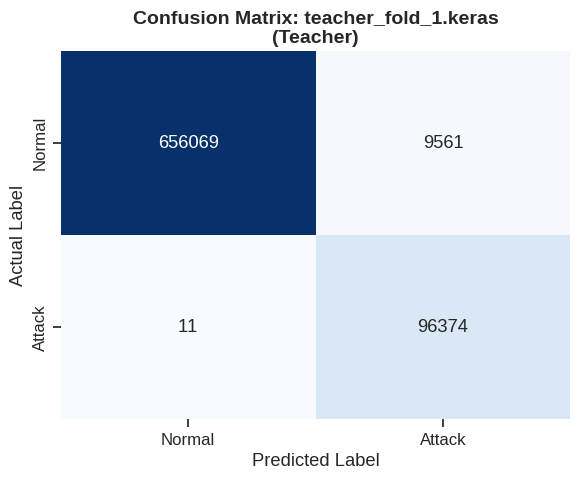


🥊 Starting Student Evaluation...
   ⏱️ Running inference on R1_RobustTiny...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step
   ✅ Done with R1_RobustTiny
   ⏱️ Running inference on R2_RobustSmall...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
   ✅ Done with R2_RobustSmall
   ⏱️ Running inference on R3_RobustMedium...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
   ✅ Done with R3_RobustMedium
   ⏱️ Running inference on R4_RobustDeep...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
   ✅ Done with R4_RobustDeep
   ⏱️ Running inference on R5_WideFidelity...
23813/23813 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
   ✅ Done with R5_WideFidelity

🏆 FINAL LEADERBOARD
                Model    Type   Recall  Precision  F1-Score  Accuracy  Size (MB)  Throughput (samples/s)
 teacher_fold_1.keras Teacher 0.999886   0.909747  0.952689  0.987439   0.787231            11563.009077
 teacher_fold_2.keras Teacher 0.999886   0.909532  0.952571  0.987406   0.787231            11672.702375
 teacher_fold_5.keras Tea

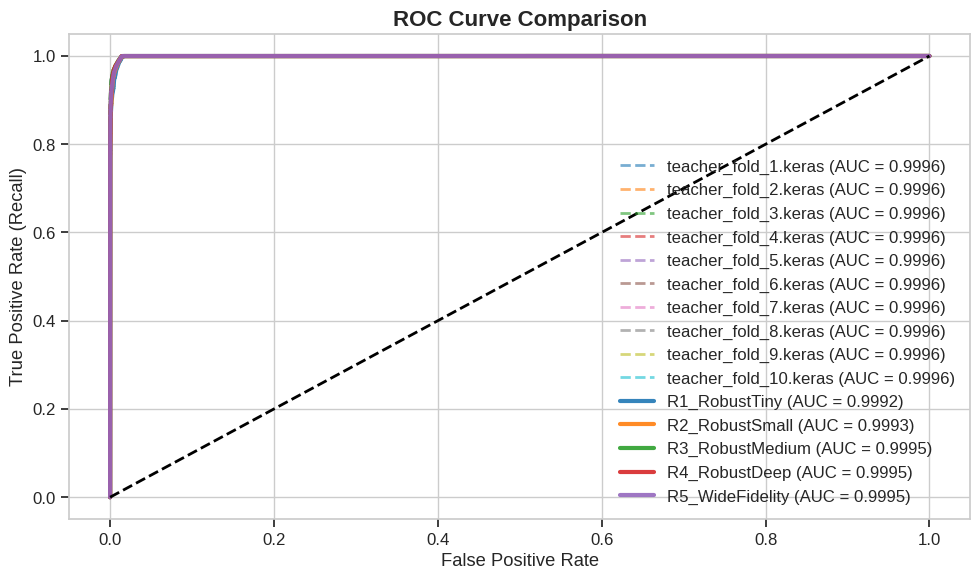

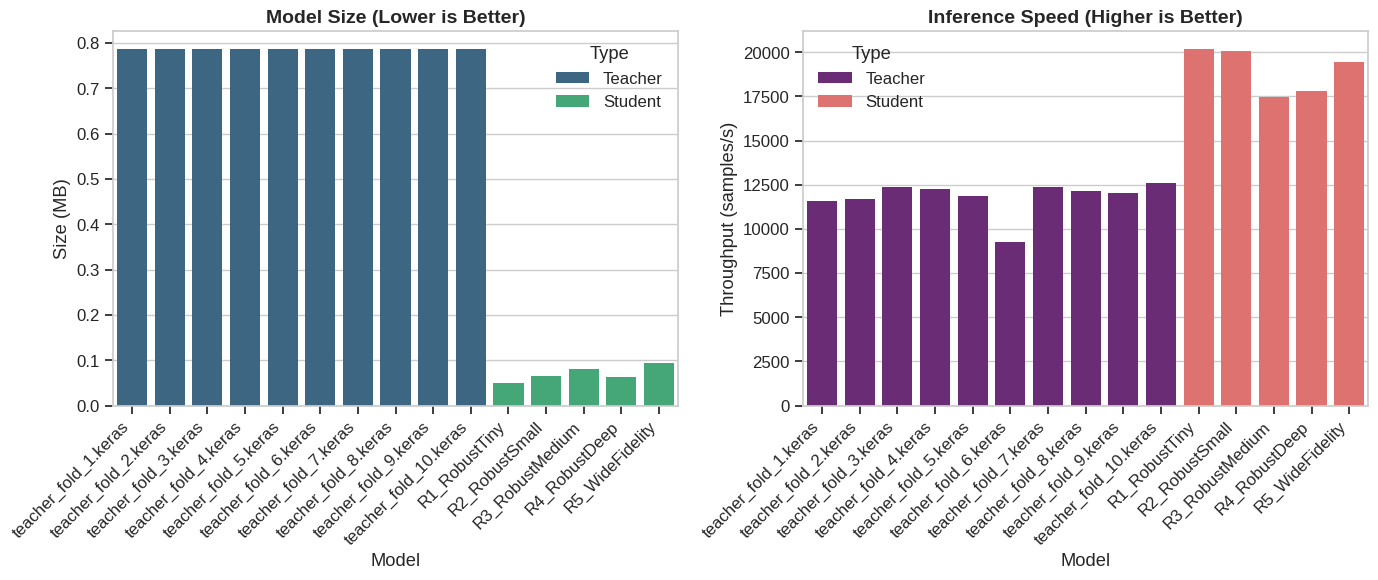


📊 Generating Confusion Matrices for ALL Students...
   (Grid plotter not found, plotting individually...)


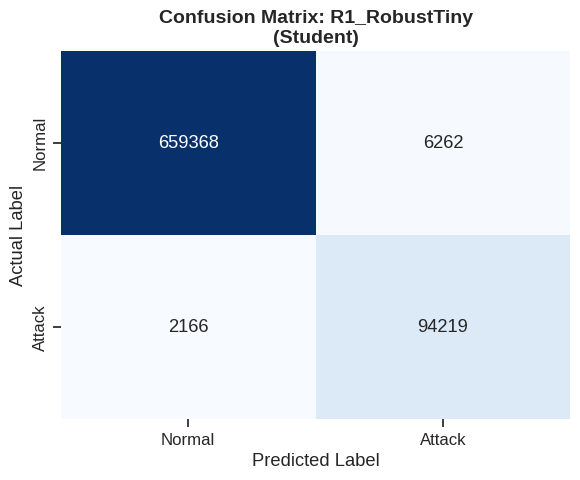

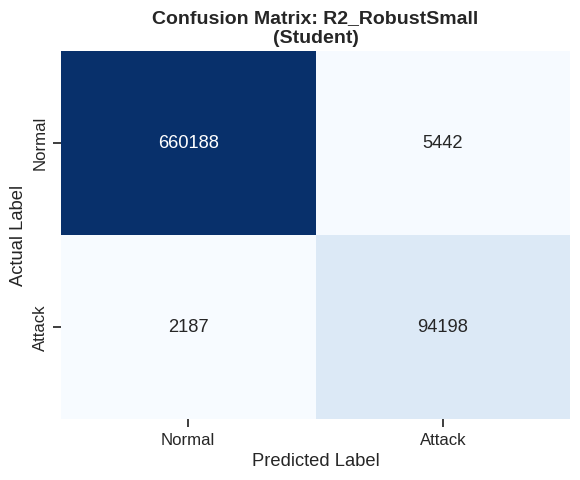

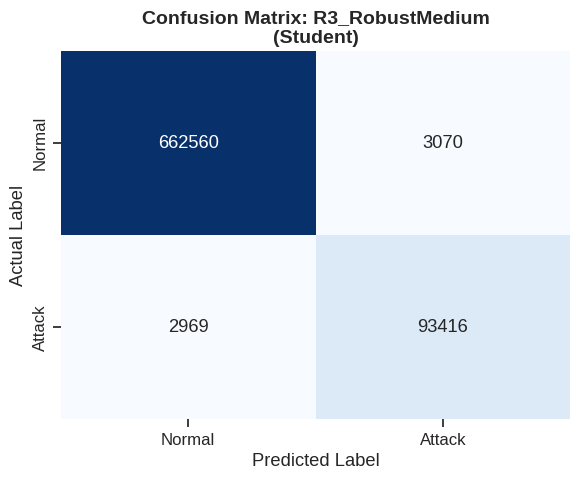

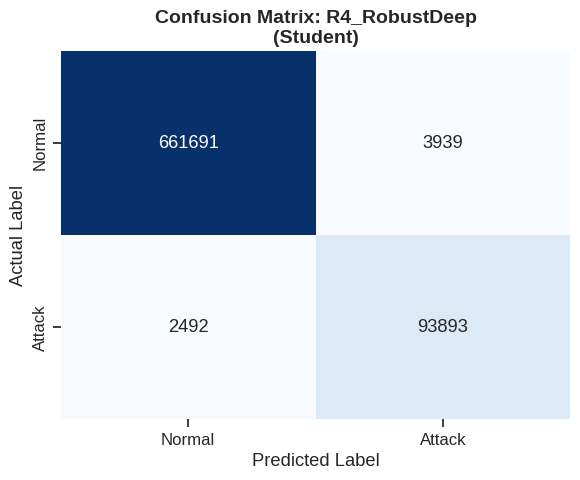

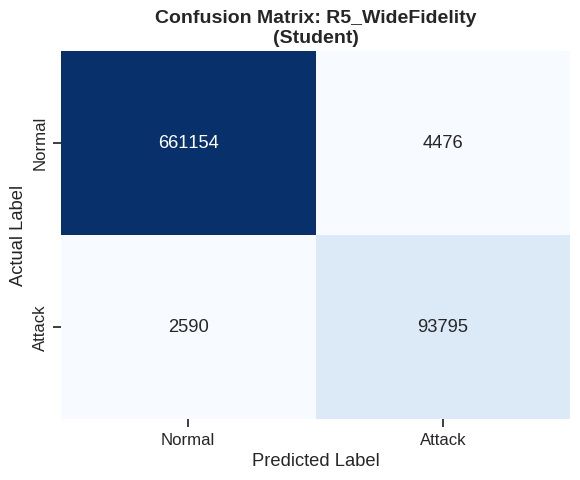

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (recall_score, precision_score, accuracy_score,
                             f1_score, log_loss, confusion_matrix,
                             roc_curve, auc)

# 🎨 Visual Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

class ModelEvaluator:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.X_test = None
        self.y_test = None
        self.X_test_reshaped = None
        self.results = []

        self._load_data()

    def _load_data(self):
        print("🔄 Loading Test Data...")
        try:
            self.X_test = pd.read_csv(os.path.join(self.dataset_path, "test_reduced.csv")).values
            self.y_test = pd.read_csv(os.path.join(self.dataset_path, "y_test.csv"))['label'].values
            # Reshape for Conv1D
            self.X_test_reshaped = np.expand_dims(self.X_test, axis=2)
            print(f"✅ Data Loaded. Shape: {self.X_test_reshaped.shape}")
        except FileNotFoundError:
            print(f"❌ Error: Test files not found in {self.dataset_path}")

    def evaluate_single_model(self, model_path, model_name, model_type="Student"):
        if not os.path.exists(model_path):
            print(f"⚠️ Model not found: {model_name}")
            return None

        try:
            # Load Model
            model = tf.keras.models.load_model(model_path, compile=False)

            print(f"   ⏱️ Running inference on {model_name}...")

            # 1. Inference
            start_time = time.time()
            logits = model.predict(self.X_test_reshaped, verbose=1)
            end_time = time.time()

            # Predictions
            probs = tf.nn.softmax(logits).numpy()
            preds = np.argmax(probs, axis=1)

            # 2. Calculate Metrics
            prec = precision_score(self.y_test, preds, pos_label=1)
            rec = recall_score(self.y_test, preds, pos_label=1)
            f1 = f1_score(self.y_test, preds, pos_label=1)
            acc = accuracy_score(self.y_test, preds)

            metrics = {
                "Model": model_name,
                "Type": model_type,
                "Path": model_path,
                "Accuracy": acc,
                "Recall": rec,
                "Precision": prec,
                "F1-Score": f1,
                "Log Loss": log_loss(self.y_test, probs),
                "Inference Time (s)": end_time - start_time,
                "Throughput (samples/s)": len(self.X_test) / (end_time - start_time),
                "Size (MB)": os.path.getsize(model_path) / (1024 * 1024),
                "Probs": probs,
                "Preds": preds
            }

            self.results.append(metrics)
            return metrics

        except Exception as e:
            print(f"❌ Error evaluating {model_name}: {e}")
            return None

    def find_best_teacher(self):
        print("\n🔍 Scanning for Teacher Models...")
        teacher_files = glob.glob(os.path.join(self.dataset_path, "teacher_fold_*.keras"))

        if not teacher_files:
            print("❌ No teacher models found.")
            return None

        best_score = -1
        best_teacher = None

        for i, t_path in enumerate(teacher_files):
            name = os.path.basename(t_path)
            # print(f"   [{i+1}/{len(teacher_files)}] 🔍 Checking: {name}") # Optional progress log
            metrics = self.evaluate_single_model(t_path, name, model_type="Teacher")

            if metrics and metrics['Recall'] > best_score:
                best_score = metrics['Recall']
                best_teacher = metrics

        if best_teacher:
            print(f"\n✅ Best Teacher Selected: {best_teacher['Model']} (Recall: {best_score:.4f})")
        return best_teacher

    def evaluate_students(self, config_names):
        print("\n🥊 Starting Student Evaluation...")
        for config in config_names:
            path = os.path.join(self.dataset_path, f"student_{config}.keras")
            if os.path.exists(path):
                self.evaluate_single_model(path, config, model_type="Student")
                print(f"   ✅ Done with {config}")
            else:
                print(f"   ⚠️ Missing model file for: {config}")

    def plot_confusion_matrix(self, metrics, title_suffix=""):
        if not metrics: return
        cm = confusion_matrix(self.y_test, metrics['Preds'])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
        plt.title(f"Confusion Matrix: {metrics['Model']}\n{title_suffix}", fontsize=14, fontweight='bold')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    def generate_report(self):
        if not self.results: return

        df = pd.DataFrame(self.results)

        # 1. LEADERBOARD
        print("\n" + "="*100)
        print("🏆 FINAL LEADERBOARD")
        print("="*100)
        cols = ['Model', 'Type', 'Recall', 'Precision', 'F1-Score', 'Accuracy', 'Size (MB)', 'Throughput (samples/s)']
        print(df[cols].sort_values(by='Recall', ascending=False).to_string(index=False))
        print("="*100)

        # 2. PLOT: ROC Curves
        plt.figure(figsize=(10, 6))
        for res in self.results:
            y_score = res['Probs'][:, 1]
            fpr, tpr, _ = roc_curve(self.y_test, y_score)
            roc_auc = auc(fpr, tpr)

            style = '--' if res['Type'] == 'Teacher' else '-'
            lw = 3 if res['Type'] == 'Student' else 2
            alpha = 0.9 if res['Type'] == 'Student' else 0.6

            plt.plot(fpr, tpr, linestyle=style, linewidth=lw, alpha=alpha,
                     label=f"{res['Model']} (AUC = {roc_auc:.4f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curve Comparison', fontsize=16, fontweight='bold')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        # 3. PLOT: Bar Charts (Size vs Speed) - RESTORED
        plt.figure(figsize=(14, 6))

        # Subplot 1: Model Size
        plt.subplot(1, 2, 1)
        sns.barplot(data=df, x='Model', y='Size (MB)', hue='Type', palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.title('Model Size (Lower is Better)', fontsize=14, fontweight='bold')
        plt.ylabel('Size (MB)')

        # Subplot 2: Inference Speed
        plt.subplot(1, 2, 2)
        sns.barplot(data=df, x='Model', y='Throughput (samples/s)', hue='Type', palette='magma')
        plt.xticks(rotation=45, ha='right')
        plt.title('Inference Speed (Higher is Better)', fontsize=14, fontweight='bold')
        plt.ylabel('Throughput (samples/s)')

        plt.tight_layout()
        plt.show()

        return df


# --- EXECUTION ---
if __name__ == "__main__":
    dataset_path = '/content/drive/MyDrive/BTP'

    evaluator = ModelEvaluator(dataset_path)

    # 1. Evaluate Teacher
    best_teacher = evaluator.find_best_teacher()
    if best_teacher:
        evaluator.plot_confusion_matrix(best_teacher, title_suffix="(Teacher)")

    # 2. Evaluate Students
    student_configs = ["R1_RobustTiny", "R2_RobustSmall", "R3_RobustMedium", "R4_RobustDeep", "R5_WideFidelity"]
    evaluator.evaluate_students(student_configs)

    # 3. Generate Report (Table + ROC + Bar Charts)
    results_df = evaluator.generate_report()

    # 4. Plot Confusion Matrices for ALL Students
    if not results_df.empty:
        print("\n📊 Generating Confusion Matrices for ALL Students...")

        # Option A: Plot them side-by-side in a grid (Recommended - cleaner)
        # Ensure you added the method 'plot_all_students_grid' to the class above!
        try:
            evaluator.plot_all_students_grid()
        except AttributeError:
            # Fallback if you didn't add the helper method
            print("   (Grid plotter not found, plotting individually...)")
            students = [res for res in evaluator.results if res['Type'] == 'Student']
            for s in students:
                evaluator.plot_confusion_matrix(s, title_suffix="(Student)")

In [ ]:
#Real Time Simulation
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import pickle
import time
import glob
import warnings
import sys

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

class LiveTrafficSimulator:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        if not os.path.exists(self.dataset_path):
            print(f"❌ Error: Dataset path not found: {self.dataset_path}")
            sys.exit(1)

        self.models = []
        self.assets = {}
        self.model_stats = {}

        # Standard UNSW-NB15 Columns
        self.raw_col_names = [
            'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
            'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
            'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
            'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
            'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
            'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
            'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label'
        ]

        print("🔌 Initializing Live Traffic Simulator...")
        self._load_assets()
        self._load_models()

    def _load_assets(self):
        print("   🔄 Loading System Assets...")
        try:
            with open(os.path.join(self.dataset_path, 'label_encoders.pkl'), 'rb') as f:
                self.assets['encoders'] = pickle.load(f)
            with open(os.path.join(self.dataset_path, 'scaler.pkl'), 'rb') as f:
                self.assets['scaler'] = pickle.load(f)
            with open(os.path.join(self.dataset_path, 'selected_features.pkl'), 'rb') as f:
                self.assets['selected_features'] = pickle.load(f)
            print(f"   ✅ Assets Loaded (Top {len(self.assets['selected_features'])} features).")
        except Exception as e:
            print(f"   ⚠️ Critical Asset Missing: {e}")
            sys.exit(1)

    def _load_models(self):
        print("   🔄 Loading Neural Networks...")
        # Load Teacher
        t_files = glob.glob(os.path.join(self.dataset_path, "teacher_fold_*.keras"))
        if t_files:
            best = next((f for f in t_files if 'fold_1' in f), t_files[0])
            try:
                model = tf.keras.models.load_model(best, compile=False)
                self.models.append({'name': 'Teacher (Heavy)', 'model': model})
                self.model_stats['Teacher (Heavy)'] = {'correct': 0, 'total': 0, 'latency': []}
            except: pass

        # Load Students
        student_names = ["R1_RobustTiny", "R2_RobustSmall", "R3_RobustMedium", "R4_RobustDeep", "R5_WideFidelity"]
        for s_name in student_names:
            path = os.path.join(self.dataset_path, f"student_{s_name}.keras")
            if os.path.exists(path):
                try:
                    model = tf.keras.models.load_model(path, compile=False)
                    model_name = f"Student ({s_name})"
                    self.models.append({'name': model_name, 'model': model})
                    self.model_stats[model_name] = {'correct': 0, 'total': 0, 'latency': []}
                    print(f"   ✅ Loaded Student: {s_name}")
                except: pass

    def _get_random_packet(self):
        raw_files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv']
        for r_file in raw_files:
            p = os.path.join(self.dataset_path, r_file)
            if os.path.exists(p):
                try:
                    file_size = os.path.getsize(p)
                    start = np.random.randint(0, max(1, file_size - 5000))
                    with open(p, 'r') as f:
                        f.seek(start)
                        f.readline()
                        line = f.readline()
                    from io import StringIO
                    df_chunk = pd.read_csv(StringIO(line), header=None, names=self.raw_col_names)
                    return df_chunk
                except: continue
        return None

    def _preprocess(self, packet_raw):
        # 1. Clean names
        packet_raw.columns = packet_raw.columns.str.lower().str.strip()

        # 2. Encode
        if 'encoders' in self.assets:
            for col, le in self.assets['encoders'].items():
                col_clean = col.lower().strip()
                if col_clean in packet_raw.columns:
                    val = str(packet_raw[col_clean].values[0])
                    packet_raw[col_clean] = le.transform([val])[0] if val in le.classes_ else -1

        # 3. Scale
        numeric_cols = packet_raw.select_dtypes(include=[np.number]).columns
        features_df = packet_raw[numeric_cols].drop(columns=['label', 'attack_cat'], errors='ignore')
        scaler = self.assets['scaler']

        # --- FIX: Force align column names with Scaler's expectations ---
        # This fixes the "ct_src_ltm" vs "ct_src_ ltm" mismatch
        if hasattr(scaler, 'feature_names_in_'):
             if len(features_df.columns) == len(scaler.feature_names_in_):
                 features_df.columns = scaler.feature_names_in_
        # ---------------------------------------------------------------

        if features_df.shape[1] == scaler.n_features_in_:
            scaled_data = scaler.transform(features_df)
            scaled_df = pd.DataFrame(scaled_data, columns=features_df.columns)
        else:
             scaled_df = features_df

        # 4. Select Top Features
        top_features = self.assets['selected_features']
        final_data = []
        for f in top_features:
            # Robust lookup in case of further typos
            if f in scaled_df.columns:
                val = scaled_df[f].values[0]
            else:
                # Try matching stripped version
                match = next((c for c in scaled_df.columns if c.strip() == f.strip()), None)
                val = scaled_df[match].values[0] if match else 0.0

            final_data.append(val)

        return np.expand_dims(np.array([final_data]), axis=2)

    # Modified run method to process a single packet per call
    def run_single_packet(self, step_num, total_steps):
        packet = self._get_random_packet()
        if packet is None: return None

        proto = packet['proto'].values[0] if 'proto' in packet else 'TCP'
        src = packet['srcip'].values[0] if 'srcip' in packet else '192.168.1.1'
        true_label = packet['label'].values[0] if 'label' in packet else 0
        gt_text = "🔴 ATTACK" if true_label == 1 else "🟢 NORMAL"

        print(f"\n[{step_num}/{total_steps}] Packet: {str(proto).upper()} | Source: {src}")
        print(f"      Ground Truth: {gt_text}")
        print("-" * 75)
        print(f"   {'Model':<30} | {'Prediction':<10} | {'Conf.':<8} | {'Latency':<10} | {'Result'}")
        print("-" * 75)

        input_tensor = self._preprocess(packet.copy())

        for m in self.models:
            start = time.time()
            logits = m['model'].predict(input_tensor, verbose=0)
            end = time.time()

            probs = tf.nn.softmax(logits).numpy()
            pred_idx = np.argmax(probs)
            conf = probs[0, pred_idx] # Accesses the first row, then the specific index
            latency = (end - start) * 1000

            res_text = "🔴 Attack" if pred_idx == 1 else "🟢 Normal"
            is_correct = (pred_idx == true_label)
            icon = "✅" if is_correct else "❌"

            name = m['name']
            self.model_stats[name]['total'] += 1
            self.model_stats[name]['latency'].append(latency)
            if is_correct:
                self.model_stats[name]['correct'] += 1

            print(f"   {name:<30} | {res_text:<10} | {conf*100:.1f}%    | {latency:.2f} ms   | {icon}")

        time.sleep(0.5)
        return True

    def _summarize(self):
        print("\n" + "="*60)
        print("📊 SIMULATION SESSION SUMMARY")
        print("="*60)
        print(f"{'Model':<30} | {'Accuracy':<10} | {'Avg Latency'}")
        print("-" * 60)

        best_model = None
        best_acc = -1

        for name, stats in self.model_stats.items():
            if stats['total'] == 0: continue
            acc = (stats['correct'] / stats['total']) * 100
            avg_lat = np.mean(stats['latency'])

            print(f"{name:<30} | {acc:.1f}%      | {avg_lat:.2f} ms")

            if "Student" in name:
                if acc > best_acc:
                    best_acc = acc
                    best_model = name
                elif acc == best_acc:
                    current_best_stats = self.model_stats[best_model]
                    if avg_lat < np.mean(current_best_stats['latency']):
                        best_model = name

        print("="*60)
        print(f"🌟 Best Performing Student: {best_model}")
        return best_model

if __name__ == "__main__":
    dataset_path = '/content/drive/MyDrive/BTP'
    sim = LiveTrafficSimulator(dataset_path)

    if sim.models:
        total_steps = 100
        print("\n" + "="*60)
        print("📡  CAPTURING NETWORK TRAFFIC (UNSW-NB15 Stream)")
        print("="*60)

        for i in range(total_steps):
            sim.run_single_packet(i + 1, total_steps)

        best_model_name = sim._summarize()
        print(f"\nSelected for Deployment: {best_model_name}")
    else:
        print("No models found. Please train first.")

🔌 Initializing Live Traffic Simulator...
   🔄 Loading System Assets...
   ✅ Assets Loaded (Top 15 features).
   🔄 Loading Neural Networks...
   ✅ Loaded Student: R1_RobustTiny
   ✅ Loaded Student: R2_RobustSmall
   ✅ Loaded Student: R3_RobustMedium
   ✅ Loaded Student: R4_RobustDeep
   ✅ Loaded Student: R5_WideFidelity

📡  CAPTURING NETWORK TRAFFIC (UNSW-NB15 Stream)

[1/100] Packet: UDP | Source: 59.166.0.5
      Ground Truth: 🟢 NORMAL
---------------------------------------------------------------------------
   Model                          | Prediction | Conf.    | Latency    | Result
---------------------------------------------------------------------------
   Teacher (Heavy)                | 🟢 Normal   | 73.1%    | 524.07 ms   | ✅
   Student (R1_RobustTiny)        | 🟢 Normal   | 83.6%    | 240.85 ms   | ✅
   Student (R2_RobustSmall)       | 🟢 Normal   | 85.9%    | 205.88 ms   | ✅
   Student (R3_RobustMedium)      | 🟢 Normal   | 85.0%    | 169.48 ms   | ✅


   Student (R4_RobustDeep)        | 🟢 Normal   | 82.7%    | 169.71 ms   | ✅
   Student (R5_WideFidelity)      | 🟢 Normal   | 87.2%    | 143.06 ms   | ✅

[2/100] Packet: TCP | Source: 59.166.0.5
      Ground Truth: 🟢 NORMAL
---------------------------------------------------------------------------
   Model                          | Prediction | Conf.    | Latency    | Result
---------------------------------------------------------------------------
   Teacher (Heavy)                | 🟢 Normal   | 73.1%    | 79.85 ms   | ✅
   Student (R1_RobustTiny)        | 🟢 Normal   | 83.6%    | 83.42 ms   | ✅
   Student (R2_RobustSmall)       | 🟢 Normal   | 86.0%    | 80.49 ms   | ✅
   Student (R3_RobustMedium)      | 🟢 Normal   | 85.0%    | 80.62 ms   | ✅
   Student (R4_RobustDeep)        | 🟢 Normal   | 82.7%    | 77.74 ms   | ✅
   Student (R5_WideFidelity)      | 🟢 Normal   | 87.3%    | 75.27 ms   | ✅

[3/100] Packet: TCP | Source: 59.166.0.1
      Ground Truth: 🟢 NORMAL
------------------------